Data overview: Figure 1
----

Make all plots for Figure 1

- UMAP cell type annotation, cortex area, condition
- Distribution of counts
- Cell type annotation marker map

## Dependecy notebooks

TODO: define here links to other notebooks which need to be run in the correct order prior
to running this notebook (e.g. data preprocessing/data generation).
If there aren't any, remove this section.  
Also name your notebooks beginning with numbers: 01_quality_control.ipynb, 02_normalisation.ipynb, ...

## Import packages

If you want modules to be automatically reloaded when you call them, use `autoreload`:

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import packages

In [30]:
# import standard packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
from pathlib import Path

# import single-cell packages
import scanpy as sc

# set verbosity levels
sc.settings.verbosity = 2

# ignore user warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore', category=UserWarning)

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

## Set up paths

Define global paths.

In [7]:
sys.path.insert(0, "../")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, RESULTS_DIR, FIG_DIR
from colors import AREA_COLOR, CELL_TYPES_COLOR, CONDITION_COLOR
from utils.marker_genes import CANONICAL_MARKERS, old_canonical_marker, amyloid_plaque_human
from utils.canonical_marker_gex import plot_gene_expression_by_area, plot_marker_gene_expression_comparison
#from utils.qc import statistical_test_boxplot, 

Set up the paths to save figures.

In [8]:
FIG_DIR = Path(FIG_DIR, 'data_overview')
sc.settings.figdir = str(FIG_DIR)
#scv.settings.figdir = str(FIG_DIR)
#cr.settings.figdir = str(FIG_DIR)

## Set global parameters

Set some plotting parameters.

In [9]:
plt.rcParams['figure.dpi'] = 90
plt.rcParams['savefig.dpi'] = 300 # If 'figure', uses the figure's dpi value.
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

If there are other global parameters for this analysis, put them here as well. 

## Define utility functions

Any utility functions you may need in this notebook go here. 

In [10]:
from utils.utils import SAMPLES, VERSION

In [11]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

In [12]:
cell_type_dict = {
    "astro": "Astrocytes",
    "Micro": "Microglia",
    "OPC": "OPC",
    "Oligo": "Oligodendrocytes",
    "GlutaNeuron": "Excitatory neurons",
    "GABANeuron": "Inhibitory neurons",
    "Endo": "Endo",
    "VLMC": "VLMC"
}

## Load the data

In [13]:
adata = sc.read_h5ad(DATA_DIR / f"{VERSION}_adata_annotated_sea.h5ad")
adata

AnnData object with n_obs × n_vars = 29656 × 34859
    obs: 'sample', 'condition', 'area', 'age', 'donor', 'sequencing batch', 'sequencing id', 'sex', 'APOE genotype', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area', 'n_counts', 'log_counts', 'n_genes', 'tech_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_nuclear', 'log1p_total_counts_nuclear', 'pct_counts_nuclear', 'braak_stage', 'area_abbrev', 'condition_area', 'brainbank', 'brain_area_latin', 'soupx_groups', 'scDblFinder_score', 'scDblFinder_class', 'leiden', 'mt_groups', 'tech_sample_2', 'log1p_counts', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_2.0', 'celltype', 'cell_type', 'cell_type_sea'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'ribo', 'hb', 'nuclear', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_co

In [87]:
print('Nr. cells: ', len(adata.obs_names))

Nr. cells:  29656


In [88]:
# filter out all genes that occur in less than 20 cells
adata = adata[:, (adata.layers['raw'] > 0.).sum(axis=0) > 20.].copy()
print('Nr. cells: ', len(adata.obs_names))

Nr. cells:  29656


Get embedding from integration methods.

In [89]:
adata_int = sc.read_h5ad(Path(DATA_DIR / f"{VERSION}_adata_sea_integrated_donor.h5ad")) # _adata_sea_integrated_woNaN
print('Nr. cells: ', len(adata_int.obs_names), 'Nr. genes: ', len(adata_int.var_names))

Nr. cells:  29656 Nr. genes:  5000


In [90]:
assert len(adata.obs_names) == len(adata_int.obs_names), f"Nr. cells is not equal: {len(adata.obs_names)}, {len(adata_int.obs_names)}"

In [91]:
adata.obsm['X_scANVI'] = adata_int.obsm['X_scANVI']
adata.obsm['X_scVI'] = adata_int.obsm['X_scVI']

In [92]:
del adata_int

In [93]:
sc.pp.filter_genes(adata, min_cells=10) 
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=5000, batch_key = 'donor')

extracting highly variable genes
    finished (0:00:04)


In [94]:
#sc.tl.pca(adata, use_highly_variable = True)
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep = 'X_scVI')
sc.tl.umap(adata)

computing PCA
    with n_comps=50
    finished (0:00:07)
computing neighbors
    finished (0:00:23)
computing UMAP
    finished (0:00:12)


In [95]:
adata.uns["cell_type_sea_colors"] = np.array(list(CELL_TYPES_COLOR.values()))

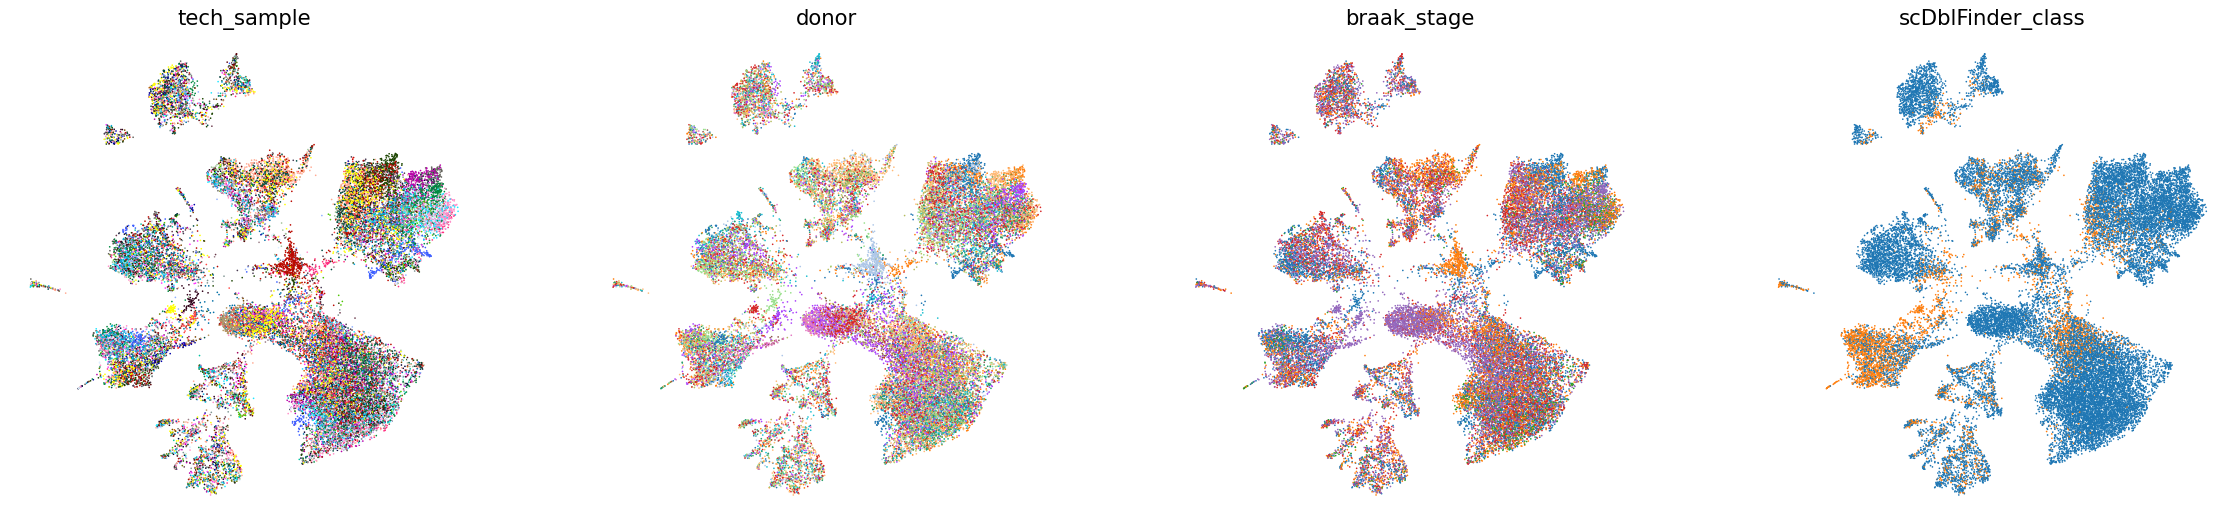

In [96]:
sc.pl.umap(adata, color=['tech_sample', 'donor', 'braak_stage', 'scDblFinder_class'], ncols=4, frameon = False, size =7, legend_loc = None)

**Interpretation**: OPC have high fraction of doublet cells. Are they co-expressing gene markers from other cell type clusters? OPCs are dividing faster and transitioning into other cell types, so should be that strict with the thresholing. 

We can still observe that some cells that cluster together are doublets or from one single donor. Lets remove them. 

In [102]:
adata.uns["cell_type_sea_colors"] = np.array(list(CELL_TYPES_COLOR.values()))

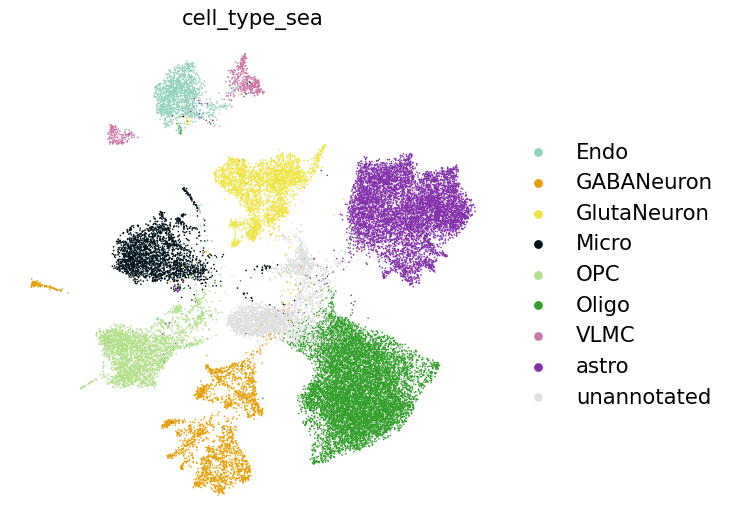

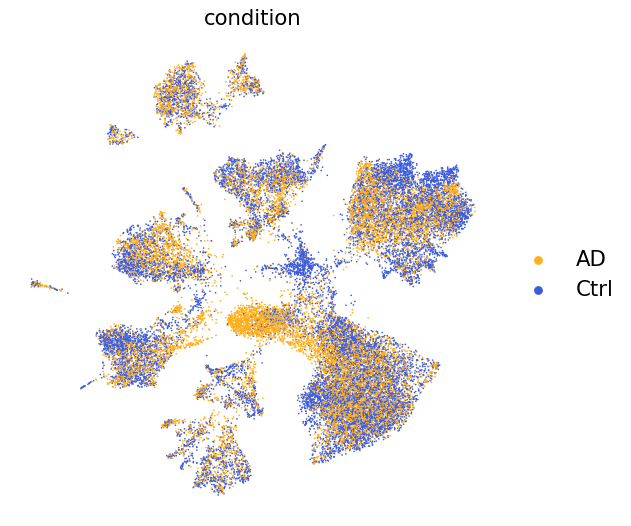

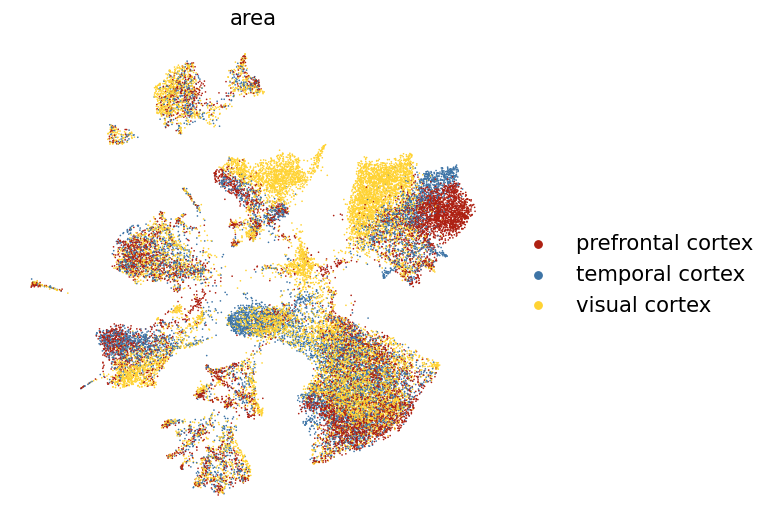

In [103]:
plt.rcParams['figure.figsize']= (7, 7)
for label, colors_dict in [('cell_type_sea', CELL_TYPES_COLOR) , ('condition', CONDITION_COLOR), ('area', AREA_COLOR)]:
    # del adata.uns[label + "_colors"]
    #adata.uns[label + "_colors"] = np.array(colors_dict.values())
    sc.pl.umap(adata, color=[label], ncols=2, frameon = False, size =7, save=f'_sea_umap_{label}_with_unannotated.png')

### Check for apoptosis/dying genes

Make sure that unannotated cells are not just dying

In [112]:
apoptosis_genes = {
    'Pro-apoptotic': [
        'BAX', 'BAK1', 'BID', 'BCL2L11',  # BCL2L11 is BIM
        'BAD', 'BBC3',  # BBC3 is PUMA
        'APAF1', 'CASP3', 'CASP7', 'CASP8', 'CASP9',
        'CYCS', 'TP53', 'DIABLO', 'ENDOG', 'AIF1'
    ],
    'Anti-apoptotic': [
        'BCL2', 'BCL2L1',  # BCL2L1 is BCL-XL
        'MCL1', 'XIAP', 'BIRC2', 'BIRC3', 'BIRC5',
        'BCL2A1', 'BCL2L2'
    ],
    'DNA damage': [
        'ATM', 'ATR', 'CDKN1A',  # CDKN1A is p21
        'GADD45A', 'GADD45B', 'GADD45G',
        'MDM2', 'CDKN2A', 'RB1', 'E2F1'
    ],
    'Stress response': [
        'JUN', 'FOS', 'DDIT3',  # DDIT3 is CHOP
        'HSPA1A', 'HSPA1B', 'HSP90AA1', 'HSP90AB1',
        'XBP1', 'ATF4', 'ATF6', 'ERN1'  # ERN1 is IRE1A
    ],
    'Death receptor': [
        'FAS', 'TNFRSF1A', 'TNFRSF1B',
        'TNFSF10',  # TNFSF10 is TRAIL
        'FADD', 'TRADD'
    ]
}

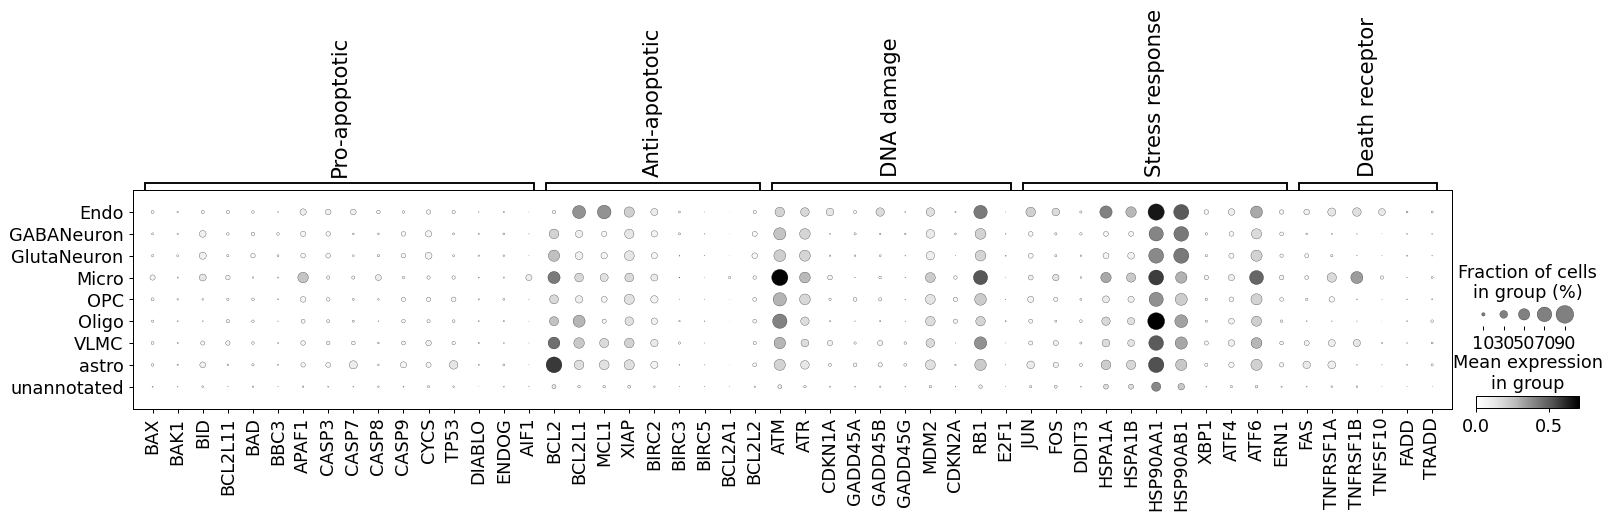

In [118]:
sc.pl.dotplot(adata, apoptosis_genes, groupby='cell_type_sea', cmap = 'Greys', log = True, save='apoptosis_dotplot_per_ct_with_unannotated.png')

## Unannotated cluster

In [14]:
adata_unannotated = adata[adata.obs['cell_type_sea'] == 'unannotated']

In [15]:
sc.tl.leiden(adata_unannotated, resolution=2.0)

running Leiden clustering
    finished (0:00:01)


In [16]:
print('Nr. cells: ', len(adata_unannotated.obs_names), 'Nr. genes: ', len(adata_unannotated.var_names))

Nr. cells:  2670 Nr. genes:  34859


In [17]:
adata_unannotated.X = adata_unannotated.layers['raw']

In [18]:
print(adata_unannotated.X[:10, :10])

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 4 stored elements and shape (10, 10)>
  Coords	Values
  (5, 2)	2.0
  (5, 6)	1.0
  (7, 2)	1.0
  (9, 4)	1.0


In [19]:
median_counts = np.median(adata_unannotated.X.sum(axis=1))
median_features = np.median((adata_unannotated.X > 0).sum(axis=1))

print(f"Median features per nucleus: {np.mean(median_features)}")
print(f"Median counts per nucleus: {np.mean(median_counts)}")

Median features per nucleus: 879.2205992509363
Median counts per nucleus: 1183.3333740234375


In [20]:
for area in np.unique(adata_unannotated.obs['area']):
    sub_adata = adata_unannotated[adata_unannotated.obs['area'] == area]
    print(area, sub_adata.obs.groupby('condition')['cell_type_sea'].value_counts(normalize=True))

del sub_adata

prefrontal cortex condition  cell_type_sea
AD         unannotated      1.0
Ctrl       unannotated      1.0
Name: proportion, dtype: float64
temporal cortex condition  cell_type_sea
AD         unannotated      1.0
Ctrl       unannotated      1.0
Name: proportion, dtype: float64
visual cortex condition  cell_type_sea
AD         unannotated      1.0
Ctrl       unannotated      1.0
Name: proportion, dtype: float64


**Cortex areas**

In [28]:
print(adata_unannotated.obs.area.value_counts(normalize=True))
print(adata_unannotated.obs.area.value_counts(normalize=False))

area
visual cortex        0.474906
temporal cortex      0.451311
prefrontal cortex    0.073783
Name: proportion, dtype: float64
area
visual cortex        1268
temporal cortex      1205
prefrontal cortex     197
Name: count, dtype: int64


In [29]:
print(adata_unannotated.obs.condition.value_counts(normalize=True))
print(adata_unannotated.obs.condition.value_counts(normalize=False))

condition
AD      0.666292
Ctrl    0.333708
Name: proportion, dtype: float64
condition
AD      1779
Ctrl     891
Name: count, dtype: int64


In [30]:
df = adata.obs[['donor_v2', 'area']]
value_counts = pd.DataFrame(df.values, columns=df.columns).value_counts()
print(value_counts)

donor_v2  area             
Ctrl3     visual cortex        384
AD2       temporal cortex      337
AD5       temporal cortex      256
AD2       visual cortex        237
AD1       visual cortex        225
AD6       temporal cortex      205
          visual cortex        168
AD1       temporal cortex      127
Ctrl4     temporal cortex      106
Ctrl1     visual cortex        103
Ctrl2     prefrontal cortex     86
AD3       temporal cortex       80
Ctrl1     temporal cortex       52
Ctrl4     prefrontal cortex     34
Ctrl2     visual cortex         28
AD5       visual cortex         27
AD7       temporal cortex       26
AD3       visual cortex         24
Ctrl5     visual cortex         24
AD7       visual cortex         23
Ctrl7     visual cortex         16
AD6       prefrontal cortex     15
Ctrl7     prefrontal cortex     15
AD7       prefrontal cortex     14
Ctrl4     visual cortex          9
AD2       prefrontal cortex      8
Ctrl5     prefrontal cortex      8
Ctrl1     prefrontal cortex

In [150]:
sc.tl.pca(adata_unannotated)
sc.pp.neighbors(adata_unannotated, use_rep = 'X_scVI')
sc.tl.umap(adata_unannotated)

computing PCA
    with n_comps=50
    finished (0:00:02)
computing neighbors
    finished (0:00:07)
computing UMAP
    finished (0:00:03)


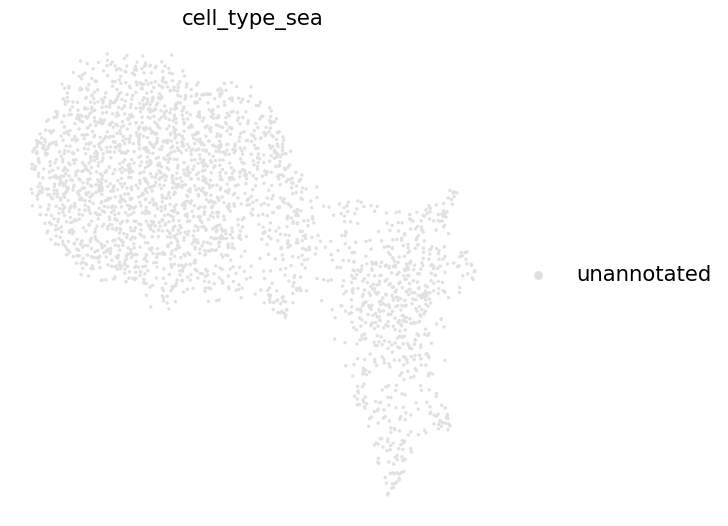

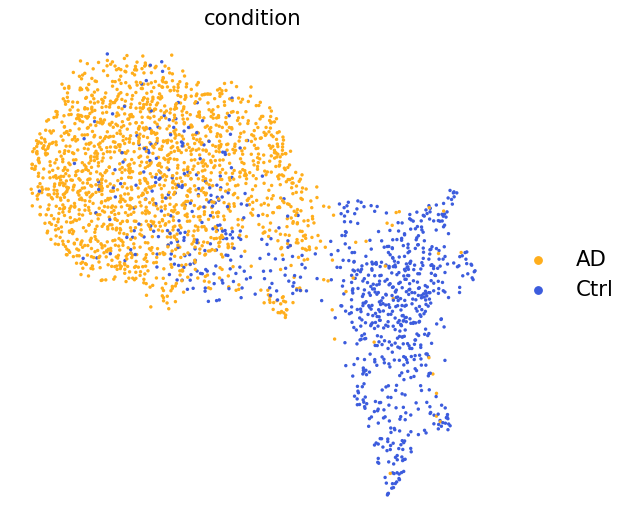

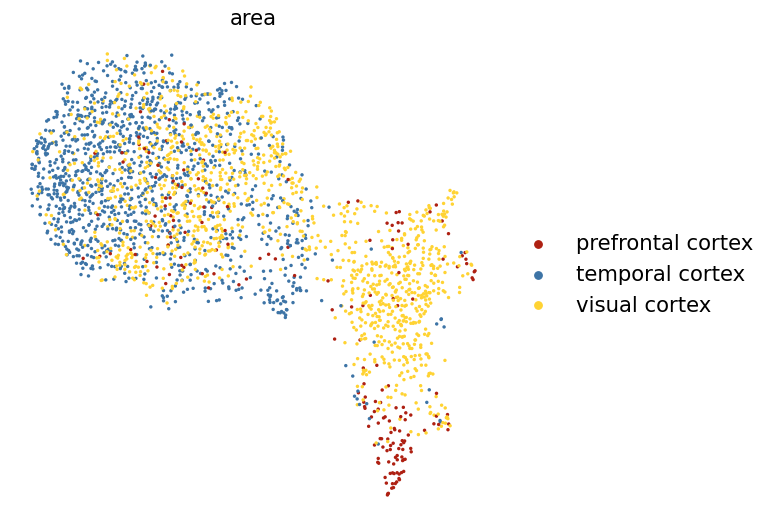

In [152]:
plt.rcParams['figure.figsize']= (7, 7)
for label, colors_dict in [('cell_type_sea', CELL_TYPES_COLOR) , ('condition', CONDITION_COLOR), ('area', AREA_COLOR)]:
    # del adata.uns[label + "_colors"]
    #adata.uns[label + "_colors"] = np.array(colors_dict.values())
    sc.pl.umap(adata_unannotated, color=[label], ncols=2, frameon = False, size =30, save=f'_sea_umap_{label}_unannotated.png')

In [155]:
adata_unannotated

AnnData object with n_obs × n_vars = 2670 × 34857
    obs: 'sample', 'condition', 'area', 'age', 'donor', 'sequencing batch', 'sequencing id', 'sex', 'APOE genotype', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area', 'n_counts', 'log_counts', 'n_genes', 'tech_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_nuclear', 'log1p_total_counts_nuclear', 'pct_counts_nuclear', 'braak_stage', 'area_abbrev', 'condition_area', 'brainbank', 'brain_area_latin', 'soupx_groups', 'scDblFinder_score', 'scDblFinder_class', 'leiden', 'mt_groups', 'tech_sample_2', 'log1p_counts', 'leiden_res_0.5', 'leiden_res_1.0', 'leiden_res_2.0', 'celltype', 'cell_type', 'cell_type_sea'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'ribo', 'hb', 'nuclear', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_cou

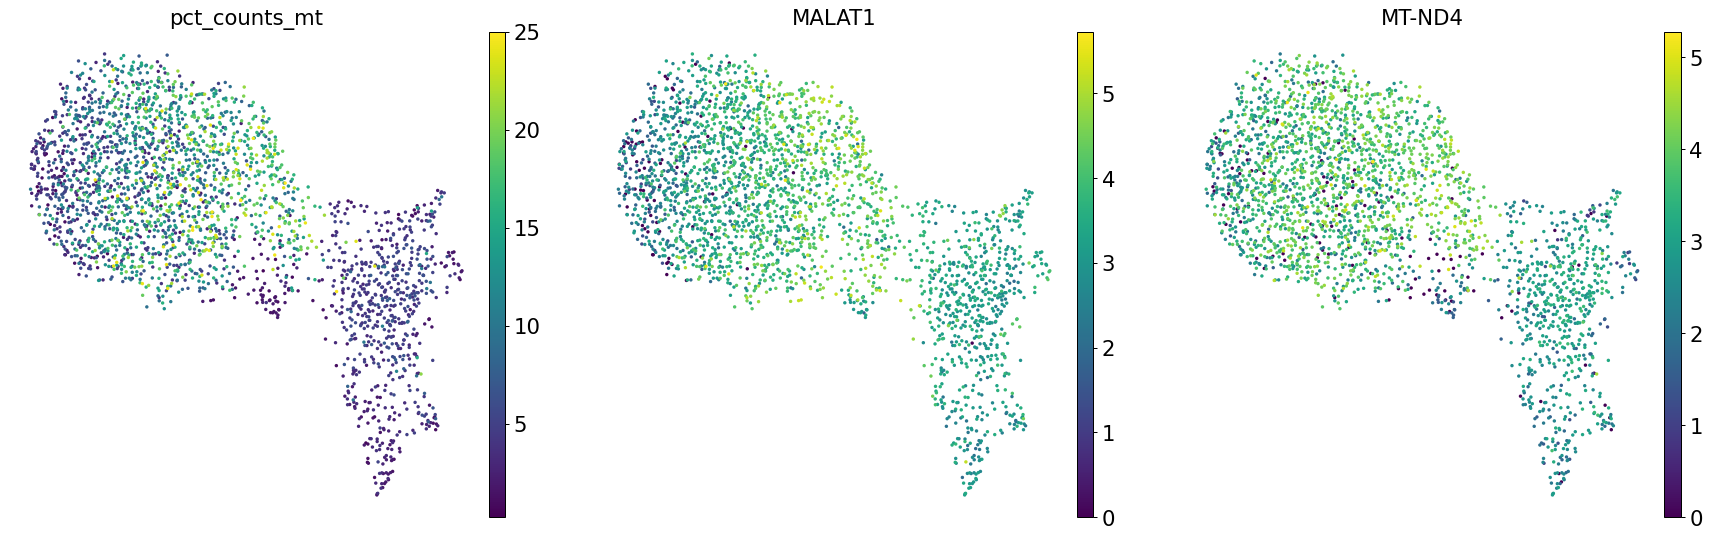

In [162]:
sc.pl.umap(adata_unannotated, color=['pct_counts_mt', 'MALAT1', 'MT-ND4'], ncols=3, frameon = False, size =30, save=f'_sea_qc_genes_unannotated.png')

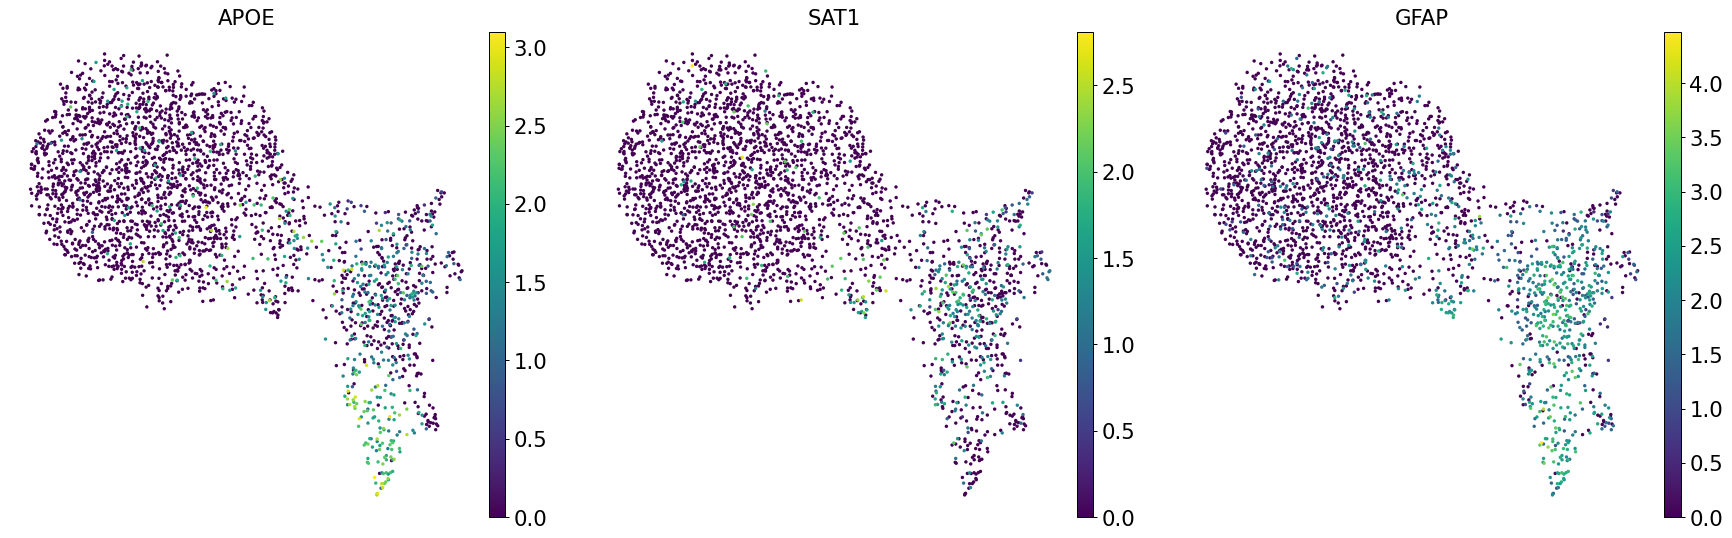

In [161]:
sc.pl.umap(adata_unannotated, color=['APOE', 'SAT1', 'GFAP'], ncols=3, frameon = False, size =30, save=f'_sea_umap_genes_unannotated.png')

### Lineage markers

Show that each cell type is correctly annotated according to marker genes

In [35]:
CANONICAL_MARKERS_FINAL = {
    "astro":[
        'SLC1A2',
        'GFAP',
        'AQP4',
    ],
    "Endo":[
        'BSG',
        'CLDN5',
        'FLT1',
    ],
    "GlutaNeuron":[
        'GRIN2A',
        'CUX2',
        'SLC17A7',
        'SYT1',
    ],
    "GABANeuron":[
        'GAD2',
        'GAD1',
        'NXPH1'
    ],
    
    "Micro":[
        "APBB1IP",
        "C3",
        "P2RY12",
    ],
    "OPC":[
        'OLIG1',
        'PDGFRA',
        'VCAN',
        'SOX10'
    ],
    "Oligo":[
        'MOBP',
        'MBP',
        'PLP1',
    ],
     "VLMC":[
        'COL1A1',
        'COL1A2',
    ],
    "Mixed lineage":[
        'RBFOX1',
        'PDE4B',
    ],
}


In [36]:
adata_unannotated.obs['cell_type'] = adata_unannotated.obs['cell_type_sea'].map(cell_type_dict)

In [37]:
CANONICAL_MARKERS_FINAL = {cell_type_dict.get(k, k): v for k, v in CANONICAL_MARKERS_FINAL.items()}

In [38]:
CANONICAL_MARKERS_FINAL

{'Astrocytes': ['SLC1A2', 'GFAP', 'AQP4'],
 'Endo': ['BSG', 'CLDN5', 'FLT1'],
 'Excitatory neurons': ['GRIN2A', 'CUX2', 'SLC17A7', 'SYT1'],
 'Inhibitory neurons': ['GAD2', 'GAD1', 'NXPH1'],
 'Microglia': ['APBB1IP', 'C3', 'P2RY12'],
 'OPC': ['OLIG1', 'PDGFRA', 'VCAN', 'SOX10'],
 'Oligodendrocytes': ['MOBP', 'MBP', 'PLP1'],
 'VLMC': ['COL1A1', 'COL1A2'],
 'Mixed lineage': ['RBFOX1', 'PDE4B']}

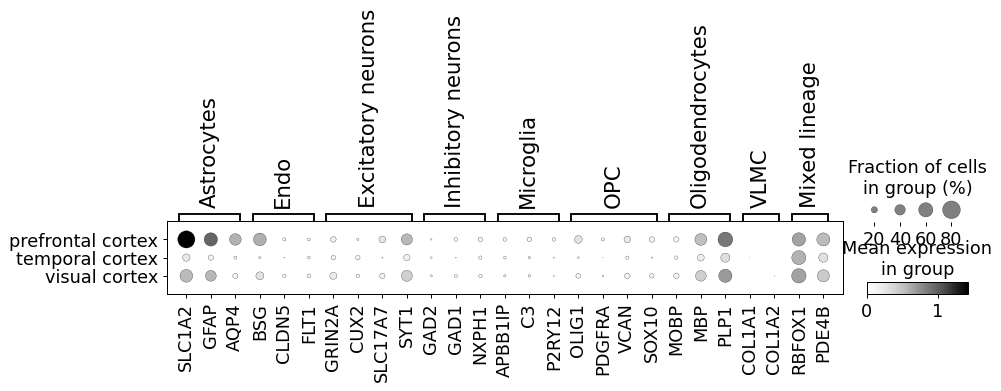

In [39]:
sc.pl.dotplot(adata_unannotated, CANONICAL_MARKERS_FINAL, groupby='area', cmap = 'Greys', log = True, save='marker_gene_dotplot_unannotated_per_area.png')

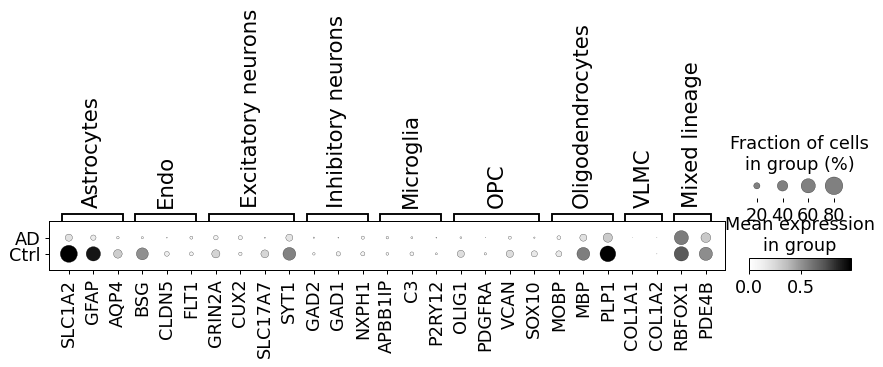

In [40]:
sc.pl.dotplot(adata_unannotated, CANONICAL_MARKERS_FINAL, groupby='condition', cmap = 'Greys', log = True, save='marker_gene_dotplot_unannotated_per_cond.png')

In [124]:
immune_genes = {
    'MHC_molecules': [
        'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DRA', 'HLA-DRB1', 'HLA-DQA1', 
        'HLA-DQB1', 'B2M', 'CD74'
    ],
    'Complement': [
        'C1QA', 'C1QB', 'C1QC', 'C3', 'C4A', 'C4B', 'CFB', 'CFD', 'CFH'
    ],
    'Interferon_response': [
        'IRF1', 'IRF3', 'IRF7', 'IRF8', 'IRF9', 'STAT1', 'STAT2', 'STAT3',
        'ISG15', 'ISG20', 'IFIT1', 'IFIT2', 'IFIT3', 'IFI27', 'IFI44L',
        'IFITM1', 'IFITM2', 'IFITM3', 'MX1', 'MX2', 'OAS1', 'OAS2', 'OAS3'
    ],
    'Cytokines_chemokines': [
        'IL1B', 'IL6', 'IL10', 'IL12A', 'IL15', 'TNF', 'IFNG', 'CXCL10',
        'CXCL9', 'CCL2', 'CCL3', 'CCL4', 'CCL5', 'CCL8', 'CX3CL1'
    ],
    'Immune_receptors': [
        'CD68', 'CD86', 'CD40', 'CD80', 'FCGR1A', 'FCGR2A', 'FCGR3A',
        'TLR2', 'TLR4', 'TLR7', 'TLR8', 'TREM2', 'TYROBP'
    ],
    'Microglial_activation': [
        'AIF1', 'ITGAM', 'CD68', 'PTPRC', 'GPNMB', 'SPP1', 'APOE',
        'TREM2', 'TYROBP', 'P2RY12', 'CX3CR1', 'CSF1R'
    ],
    'Astrocyte_reactivity': [
        'GFAP', 'VIM', 'LCN2', 'CHI3L1', 'SERPINA3', 'CP', 'GBP2',
        'STAT3', 'CXCL10', 'OSMR'
    ],
    'Oligodendrocyte_immune': [
        'CD74', 'HLA-DRA', 'APOE', 'C3', 'PTPRC', 'IRF9', 'STAT1',
        'ARHGAP24', 'CRYAB', 'SERPINH1'
    ]
}

In [125]:
# Function to filter genes that exist in your dataset
def filter_existing_genes(adata, gene_dict):
    """Filter gene dictionary to only include genes present in adata.var_names"""
    filtered_dict = {}
    for category, genes in gene_dict.items():
        existing_genes = [gene for gene in genes if gene in adata.var_names]
        if existing_genes:  # Only add categories that have at least one gene
            filtered_dict[category] = existing_genes
            print(f"{category}: {len(existing_genes)}/{len(genes)} genes found")
    return filtered_dict

In [126]:
# Filter the KEGG apoptosis genes
immune_genes_filtered = filter_existing_genes(adata, immune_genes)

MHC_molecules: 9/9 genes found
Complement: 7/9 genes found
Interferon_response: 23/23 genes found
Cytokines_chemokines: 11/15 genes found
Immune_receptors: 13/13 genes found
Microglial_activation: 12/12 genes found
Astrocyte_reactivity: 9/10 genes found
Oligodendrocyte_immune: 10/10 genes found


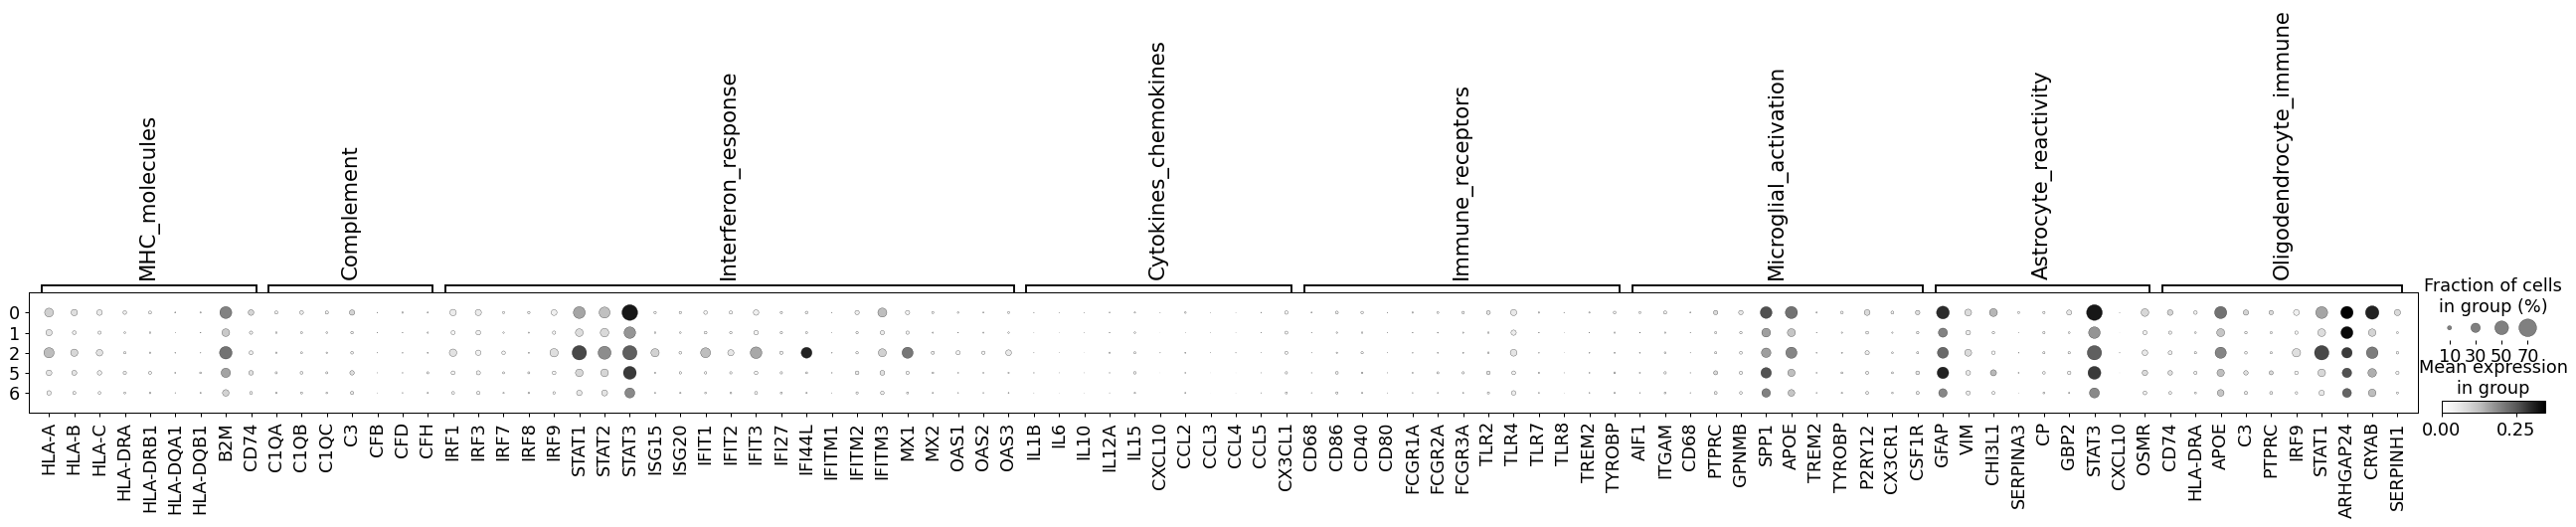

In [137]:
sc.pl.dotplot(adata, immune_genes_filtered, groupby='braak_stage', cmap = 'Greys', log = True)

In [147]:
immune_genes_selected = {
    'MHC_molecules': [
        'HLA-A', 'HLA-B', 'HLA-C', 'B2M', 'CD74'
    ],
    'Interferon_response': [
        'STAT1', 'STAT2', 'STAT3',
        'ISG15', 'IFIT1', 'IFIT2', 'IFIT3', 'IFI44L',
        'IFITM3', 'MX1', 
    ],
    'Microglial_activation': [
        'SPP1', 'APOE',
    ],
    'Astrocyte_reactivity': [
        'GFAP', 'VIM',  'CHI3L1', 'STAT3',
    ],
    'Oligodendrocyte_immune': [
        'APOE', 'C3', 'IRF9', 'STAT1',
        'ARHGAP24', 'CRYAB'
    ]
}

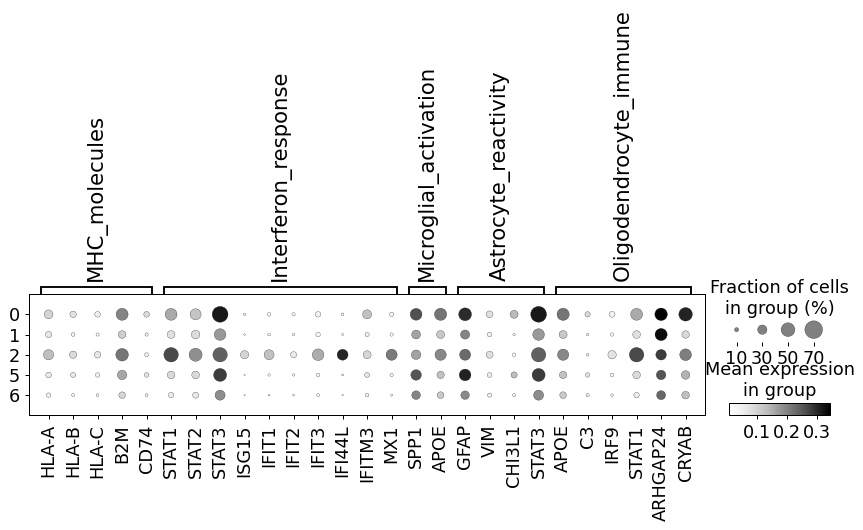

In [148]:
sc.pl.dotplot(adata, immune_genes_selected, groupby='braak_stage', cmap = 'Greys', log = True, save='immune_gene_dotplot_per_braak_stage.png')

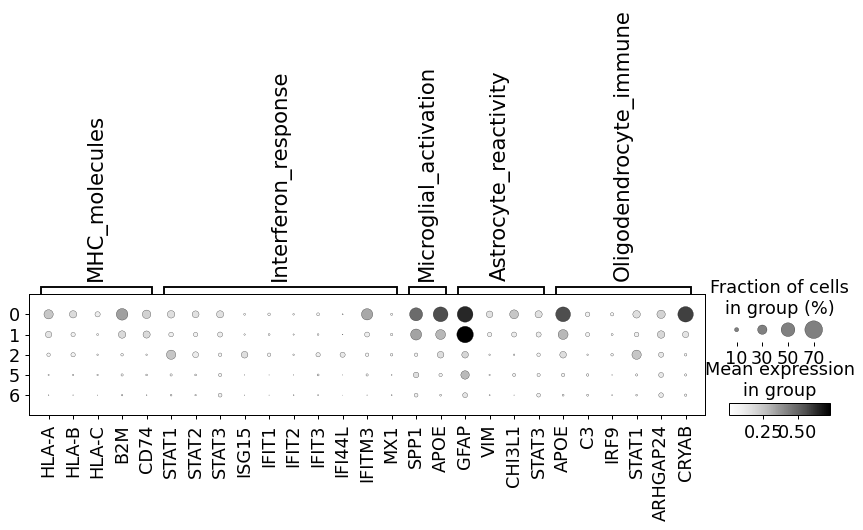

In [149]:
sc.pl.dotplot(adata_unannotated, immune_genes_selected, groupby='braak_stage', cmap = 'Greys', log = True, save='immune_gene_dotplot_unannotated_per_braak_stage.png')

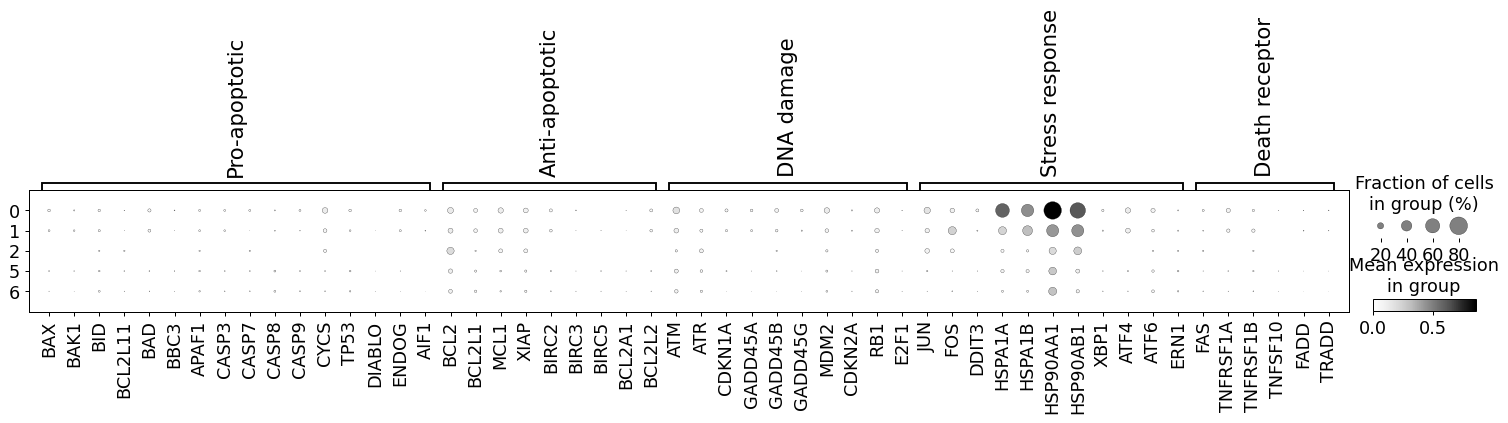

In [135]:
sc.pl.dotplot(adata_unannotated, apoptosis_genes, groupby='braak_stage', cmap = 'Greys', log = True, save='apoptosis_gene_dotplot_unannotated_per_cond.png')